In [33]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from typing import Union, Optional, Any
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from cryptodatapy.data_requests.datarequest import DataRequest
from cryptodatapy.data_requests.getdata import GetData
# from cryptodatapy.data_vendors.cryptocompare_api import CryptoCompare
# from cryptodatapy.data_vendors.ccxt_api import CCXT
import logging, sys
logging.disable(sys.maxsize)
np.seterr(divide = 'ignore') 

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
cc = CryptoCompare()

In [3]:
cx = CCXT()

In [4]:
# # get perp tickers list
# cx_perp_tickers = cx.get_assets_info(exchange='binanceusdm', as_dict=True)['binanceusdm']
# cc_tickers_list = cc.get_assets_info(as_list=True)
# perp_tickers = list(set(cx_perp_tickers).intersection(set(cc_tickers_list)))

In [5]:
# code_repo_df = cc.get_data(DataRequest(tickers=perp_tickers, 
#                                        fields=['code_repo_stars', 'code_repo_forks', 'code_repo_subscribers', 
#                                                'code_repo_open_pull_issues', 'code_repo_closed_pull_issues',
#                                                'code_repo_open_issues', 'code_repo_closed_issues', 
#                                                'code_repo_contributors']))

In [6]:
# oc_df = cc.get_data(DataRequest(tickers=['BTC', 'ETH', 'ADA'], fields=['close', 'add_act', 'tx_count']))

In [34]:
ohlcv_df = GetData(DataRequest(data_source='ccxt', 
                               tickers=['BTC', 'ETH', 'ADA'], 
                               fields=['open', 'high', 'low', 'close', 'volume'])).get_data()

In [35]:
ohlcv_df

open      high       low     close        volume
date       ticker                                                      
2017-08-17 BTC      4261.48   4485.39   4200.74   4285.08    795.150377
           ETH       301.13    312.18     298.0     302.0    7030.71034
2017-08-18 BTC      4285.08   4371.52   3938.77   4108.37   1199.888264
           ETH        302.0    311.79    283.94    293.96    9537.84646
2017-08-19 BTC      4108.37   4184.69    3850.0   4139.98    381.309763
...                     ...       ...       ...       ...           ...
2022-08-31 BTC     19813.03   20490.0  19797.94  20050.02  276946.60765
           ETH      1524.59   1619.78   1524.59    1554.1   949227.6775
2022-09-01 ADA       0.4461    0.4624    0.4407    0.4569   125016659.7
           BTC     20048.44  20208.37  19565.66  20072.15  240716.43325
           ETH      1554.11    1599.0   1512.77   1586.28   717865.7235

[5283 rows x 5 columns]

In [25]:
class OutlierDetection():
    """
    Detects outliers.
    """

    def __init__(self, raw_df: pd.DataFrame):
        """
        Constructor

        Parameters
        ----------
        raw_df: pd.DataFrame - MultiIndex
            DataFrame MultiIndex with DatetimeIndex (level 0), ticker (level 1) and raw data/values (cols).
        """
        self.raw_df = raw_df

    def atr(self, log: bool = False, window_size: int = 7, model_type: str = 'estimation', thresh_val: int = 2,
            plot: bool = False, plot_series: tuple = ('BTC', 'close')) -> dict[str, pd.DataFrame]:
        """
        Detects outliers using OHLC values and H-L range.

        Parameters
        ----------
        log: bool, default False
            Converts series into log of series.
        window_size: int, default 7
            Number of observations in the rolling window.
        model_type: str, {'estimation', 'prediction'}, default 'estimation'
            Estimation models use past, current and future values to estimate the expected value of a series,
            e.g. expected x_t of series x at time t uses values from [x_t-s, x_t+s].
            Prediction models use only past and current values to estimate the expected value of a series,
            e.g. expected x_t of series x at time t uses values from [x_t-s, x_t].
        thresh_val: int, default 2
            Value for upper and lower thresholds used in outlier detection.
        plot: bool, default False
            Plots series with outliers highlighted (red dots).
        plot_series: tuple, default ('BTC', 'close')
            The specific time series to plot given by (ticker, field/column) tuple.

        Returns
        -------
        outliers_dict: Dictionary of pd.DataFrame - MultiIndex
            Dictionary of forecasts (yhat), outliers (outliers) and filtered values (filt_vals) multiindex dataframes
            with DatetimeIndex (level 0), tickers (level 1) and fields (cols) with forecasted, outlier or filtered
            values.
        """
        # sort index and create df copy
        df = self.raw_df.sort_index(level=1)

        # log
        if log:
            df0 = np.log(df).copy()
        else:
            df0 = df.copy()

        # ohlc
        if not all(col in df.columns for col in ['open', 'high', 'low', 'close']):
            raise Exception("Dataframe must have OHLC prices to compute ATR.")

        # compute true range
        df0['hl'], df0['hc'], df0['lc'] = (df0.high - df.low).abs(), (df0.high - df.close.shift(1)).abs(), (
                df0.low - df.close.shift(1)).abs()
        df0['tr'] = df0.loc[:, 'hl':'lc'].max(axis=1)

        # compute ATR for estimation and prediction models
        if model_type == 'estimation':
            df0['atr'] = df0.tr.groupby(level=1).shift(-1 * int((window_size + 1) / 2)).sort_index(level=1). \
                rolling(window_size, min_periods=1).mean().sort_index()
            med = df0.loc[:, :'volume'].groupby(level=1).shift(-1 * int((window_size + 1) / 2)).sort_index(level=1). \
                rolling(window_size, min_periods=1).median().sort_index()
        else:
            df0['atr'] = df0.tr.groupby(level=1).ewm(span=window_size).mean().droplevel(0)
            med = df0.loc[:, :'volume'].groupby(level=1).rolling(window_size).median().droplevel(0)

        # compute dev, score and upper/lower
        dev = df0.loc[:, :'volume'] - med
        score = dev.divide(df0.atr, axis=0)
        upper, lower = thresh_val, thresh_val * -1

        # outliers
        out_df = df[(score > upper) | (score < lower)]
        filt_df = df[(score < upper) & (score > lower)]

        # log
        if log:
            med = np.exp(med)

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError("Plot_series must be a tuple specifying the ticker and column/field to "
                                "plot (ticker, column).")
            else:
                self.plot_outliers(out_df, plot_series=plot_series)

        outliers_dict = {'yhat': med.sort_index(), 'outliers': out_df.sort_index(), 'filt_vals': filt_df.sort_index()}

        return outliers_dict

    def iqr(self, log: bool = True, window_size: int = 7, model_type: str = 'estimation', thresh_val: int = 1.5,
            plot: bool = False, plot_series: tuple = ('BTC', 'close')) -> dict[str, pd.DataFrame]:
        """
        Detects outliers using interquartile range (IQR) method.

        Parameters
        ----------
        log: bool, default True
            Converts series into log of series.
        window_size: int, default 7
            Number of observations in the rolling window.
        model_type: str, {'estimation', 'prediction'}, default 'estimation'
            Estimation models use past, current and future values to estimate the expected value of a series,
            e.g. expected x_t of series x at time t uses values from [x_t-s, x_t+s].
            Prediction models use only past and current values to estimate the expected value of a series,
            e.g. expected x_t of series x at time t uses values from [x_t-s, x_t].
        thresh_val: int, default 1.5
            Value for upper and lower thresholds used in outlier detection.
            Computed as: IQR x thresh_val +/- 75th/25th percentiles (upper/lower bands), respectively.
        plot: bool, default False
            Plots series with outliers highlighted (red dots).
        plot_series: tuple, default ('BTC', 'close')
            The specific time series to plot given by (ticker, field/column) tuple.

        Returns
        -------
        outliers_dict: Dictionary of pd.DataFrame - MultiIndex
            Dictionary of forecasts (yhat), outliers (outliers) and filtered values (filt_vals) multiindex dataframes
            with DatetimeIndex (level 0), tickers (level 1) and fields (cols) with forecasted, outlier or filtered
            values.
        """
        # sort index and create df copy
        df = self.raw_df.sort_index(level=1)

        # log
        if log:
            df0 = np.log(df).copy()
        else:
            df0 = df.copy()

        # compute 75th, 50th and 25th percentiles for estimation and prediction models
        if model_type == 'estimation':
            perc_75th = df0.groupby(level=1).shift(-1 * int((window_size + 1) / 2)).sort_index(level=1). \
                rolling(window_size, min_periods=1).quantile(0.75)
            perc_25th = df0.groupby(level=1).shift(-1 * int((window_size + 1) / 2)).sort_index(level=1). \
                rolling(window_size, min_periods=1).quantile(0.25)
            med = df0.groupby(level=1).shift(-1 * int((window_size + 1) / 2)).sort_index(level=1). \
                rolling(window_size, min_periods=1).median()
        else:
            perc_75th = df0.groupby(level=1).rolling(window_size).quantile(0.75).droplevel(0)
            perc_25th = df0.groupby(level=1).rolling(window_size).quantile(0.25).droplevel(0)
            med = df0.groupby(level=1).rolling(window_size).median().droplevel(0)

        # compute iqr and upper/lower thresholds
        iqr = perc_75th - perc_25th
        upper = perc_75th.add(thresh_val * iqr, axis=1)
        lower = perc_25th.subtract(thresh_val * iqr, axis=1)

        # detect outliers
        out_df = df[(df0 > upper) | (df0 < lower)]
        filt_df = df[(df0 < upper) & (df0 > lower)]

        # log
        if log:
            med = np.exp(med)

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError("Plot_series must be a tuple specifying the ticker and column/field to "
                                "plot (ticker, column).")
            else:
                self.plot_outliers(out_df, plot_series=plot_series)

        outliers_dict = {'yhat': med.sort_index(), 'outliers': out_df.sort_index(), 'filt_vals': filt_df.sort_index()}

        return outliers_dict

    def mad(self, log: bool = True, window_size: int = 7, model_type: str = 'estimation', thresh_val: int = 10,
            plot: bool = False, plot_series: tuple = ('BTC', 'close')) -> dict[str, pd.DataFrame]:
        """
        Detects outliers using a median absolute deviation method, aka Hampler filter.

        Parameters
        ----------
        log: bool, default True
            Converts series into log of series.
        window_size: int, default 7
            Number of observations in the rolling window.
        model_type: str, {'estimation', 'prediction'}, default 'estimation'
            Estimation models use past, current and future values to estimate the expected value of a series,
            e.g. expected x_t of series x at time t uses values from [x_t-s, x_t+s].
            Prediction models use only past and current values to estimate the expected value of a series,
            e.g. expected x_t of series x at time t uses values from [x_t-s, x_t].
        thresh_val: int, default 10
            Value for upper and lower thresholds used in outlier detection.
            Computed as: [median - thresh_val * mad, median + thresh_val * mad] for lower/upper thresholds.
        plot: bool, default False
            Plots series with outliers highlighted (red dots).
        plot_series: tuple, default ('BTC', 'close')
            The specific time series to plot given by (ticker, field/column) tuple.

        Returns
        -------
        outliers_dict: Dictionary of pd.DataFrame - MultiIndex
            Dictionary of forecasts (yhat), outliers (outliers) and filtered values (filt_vals) multiindex dataframes
            with DatetimeIndex (level 0), tickers (level 1) and fields (cols) with forecasted, outlier or filtered
            values.
        """
        # sort index and create df copy
        df = self.raw_df.sort_index(level=1).copy()

        # log
        if log:
            df0 = np.log(df)
        else:
            df0 = df

        # compute median for estimation and prediction models
        if model_type == 'estimation':
            med = df0.groupby(level=1).shift(-1 * int((window_size + 1) / 2)).sort_index(level=1). \
                rolling(window_size, min_periods=1).median()
        else:
            med = df0.groupby(level=1).rolling(window_size).median().droplevel(0)

        # compute dev, mad, upper/lower thresholds
        dev = df0 - med
        mad = dev.abs().groupby(level=1).rolling(window_size).median().droplevel(0)
        upper = med.add(thresh_val * mad, axis=1)
        lower = med.subtract(thresh_val * mad, axis=1)

        # outliers
        out_df = df[(df0 > upper) | (df0 < lower)]
        filt_df = df[(df0 < upper) & (df0 > lower)]

        # log
        if log:
            med = np.exp(med)

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError("Plot_series must be a tuple specifying the ticker and column/field to "
                                "plot (ticker, column).")
            else:
                self.plot_outliers(out_df, plot_series=plot_series)

        outliers_dict = {'yhat': med.sort_index(), 'outliers': out_df.sort_index(), 'filt_vals': filt_df.sort_index()}

        return outliers_dict

    def z_score(self, log: bool = True, window_size: int = 7, model_type: str = 'estimation', thresh_val: int = 2,
                plot: bool = False, plot_series: tuple = ('BTC', 'close')) -> dict[str, pd.DataFrame]:
        """
        Detects outliers using a z-score method, aka simple moving average.

        Parameters
        ----------
        log: bool, default True
            Converts series into log of series.
        window_size: int, default 7
            Number of observations in the rolling window.
        model_type: str, {'estimation', 'prediction'}, default 'estimation'
            Estimation models use past, current and future values to estimate the expected value of a series,
            e.g. expected x_t of series x at time t uses values from [x_t-s, x_t+s].
            Prediction models use only past and current values to estimate the expected value of a series,
            e.g. expected x_t of series x at time t uses values from [x_t-s, x_t].
        thresh_val: int, default 2
            Value for upper and lower thresholds used in outlier detection.
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific ticker/field combination (tuple).

        Returns
        -------
        outliers_dict: Dictionary of pd.DataFrame - MultiIndex
            Dictionary of forecasts (yhat), outliers (outliers) and filtered values (filt_vals) multiindex dataframes
            with DatetimeIndex (level 0), tickers (level 1) and fields (cols) with forecasted, outlier or filtered
            values.
        """
        # sort index and create copy
        df = self.raw_df.sort_index(level=1).copy()

        # log
        if log:
            df0 = np.log(df)
        else:
            df0 = df

        # compute rolling mean and std for estimation and prediction models
        if model_type == 'estimation':
            roll_mean = df0.groupby(level=1).shift(-1 * int((window_size + 1) / 2)).sort_index(level=1). \
                rolling(window_size, min_periods=1).mean()
            roll_std = df0.groupby(level=1).shift(-1 * int((window_size + 1) / 2)).sort_index(level=1). \
                rolling(window_size, min_periods=1).std()
        else:
            roll_mean = df0.groupby(level=1).rolling(window_size, min_periods=1).mean().droplevel(0)
            roll_std = df0.groupby(level=1).rolling(window_size, min_periods=1).std().droplevel(0)

        # compute z-score and upper/lower thresh
        z = (df0 - roll_mean) / roll_std
        upper = thresh_val
        lower = thresh_val * -1

        # outliers
        out_df = df[(z > upper) | (z < lower)]
        filt_df = df[(z < upper) & (z > lower)]

        # log
        if log:
            roll_mean = np.exp(roll_mean)

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError("Plot_series must be a tuple specifying the ticker and column/field to "
                                "plot (ticker, column).")
            else:
                self.plot_outliers(out_df, plot_series=plot_series)

        outliers_dict = {'yhat': roll_mean.sort_index(), 'outliers': out_df.sort_index(),
                         'filt_vals': filt_df.sort_index()}

        return outliers_dict

    def ewma(self, log: bool = True, window_size: int = 7, thresh_val: int = 1.5, plot: bool = False,
             plot_series: tuple = ('BTC', 'close')) -> dict[str, pd.DataFrame]:
        """
        Detects outliers using an exponential moving average method.

        Parameters
        ----------
        log: bool, default True
            Converts series into log of series.
        window_size: int, default 7
            Number of observations in the rolling window.
        thresh_val: int, default 1.5
            Value for upper and lower thresholds used in outlier detection.
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific ticker/field combination (tuple).

        Returns
        -------
        outliers_dict: Dictionary of pd.DataFrame - MultiIndex
            Dictionary of forecasts (yhat), outliers (outliers) and filtered values (filt_vals) multiindex dataframes
            with DatetimeIndex (level 0), tickers (level 1) and fields (cols) with forecasted, outlier or filtered
            values.
        """
        # sort index and create copy
        df = self.raw_df.sort_index(level=1).copy()

        # log
        if log:
            df0 = np.log(df)
        else:
            df0 = df

        # compute ew ma and std for estimation and prediction models
        ewma = df0.groupby(level=1).ewm(span=window_size).mean().droplevel(0)
        ewstd = df0.groupby(level=1).ewm(span=window_size).std().droplevel(0)

        # compute z-score and upper/lower thresh
        z = (df0 - ewma) / ewstd
        upper = thresh_val
        lower = thresh_val * -1

        # outliers
        out_df = df[(z > upper) | (z < lower)]
        filt_df = df[(z < upper) & (z > lower)]

        # log
        if log:
            ewma = np.exp(ewma)

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError("Plot_series must be a tuple specifying the ticker and column/field to "
                                "plot (ticker, column).")
            else:
                self.plot_outliers(out_df, plot_series=plot_series)

        outliers_dict = {'yhat': ewma.sort_index(), 'outliers': out_df.sort_index(), 'filt_vals': filt_df.sort_index()}

        return outliers_dict

    def seasonal_decomp(self, log: bool = True, thresh_val: int = 5, period: int = 7, model: str = 'additive',
                        filt: Optional[np.array] = None, two_sided: Optional[bool] = True,
                        extrapolate_trend: Optional[int] = 0, plot: bool = False,
                        plot_series: tuple = ('BTC', 'close')) -> dict[str, pd.DataFrame]:
        """
        Detects outliers with seasonal decomposition moving averages from statsmodels.

        https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose

        Parameters
        ----------
        log: bool, default True
            Converts series into log of series.
        thresh_val: int, default 5
            Value for upper and lower thresholds used in outlier detection.
        period: int, optional, default 7
            periodicity of the sequence.
        model: str, {'additive', 'multiplicative'}, default 'additive'
            Type of seasonal component.
        filt: array-like, optional, default None
            The filter coefficients for filtering out the seasonal component.
            The concrete moving average method used in filtering is determined by two_sided.
        two_sided: bool, optional, default True
            The moving average method used in filtering. If True (default), a centered moving average is
            computed using the filt. If False, the filter coefficients are for past values only.
        extrapolate_trend: int, optional, default 0
            If set to > 0, the trend resulting from the convolution is linear least-squares extrapolated
            on both ends (or the single one if two_sided is False) considering this many (+1) closest points.
            If set to ‘freq’, use freq closest points. Setting this parameter results in no NaN values in trend
            or resid components.
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific (ticker, field/column) tuple.

        Returns
        -------
        outliers_dict: Dictionary of pd.DataFrame - MultiIndex
            Dictionary of forecasts (yhat), outliers (outliers) and filtered values (filt_vals) multiindex dataframes
            with DatetimeIndex (level 0), tickers (level 1) and fields (cols) with forecasted, outlier or filtered
            values.
        """
        # unstack
        df = self.raw_df.unstack().copy()
        # original idx, unstacked idx
        mult_idx, idx = self.raw_df.index, df.index

        # log
        if log:
            df0 = np.log(df)
        else:
            df0 = df

        # store resid dfs in dict
        resid_dict, yhat_dict = {}, {}
        for field in df0.columns.get_level_values(0).unique():
            resid_df, yhat_df = pd.DataFrame(index=idx), pd.DataFrame(index=idx)
            for ticker in df0[field].columns:
                # decompose
                res = seasonal_decompose(df0[field][ticker].dropna(), period=period, model=model, filt=filt,
                                         two_sided=two_sided, extrapolate_trend=extrapolate_trend)
                resid_vals, trend_vals = res.resid.fillna(0), res.trend.ffill()
                # add to dfs
                resid_df = pd.concat([resid_df, resid_vals], join='outer', axis=1).rename(columns={'resid': ticker})
                yhat_df = pd.concat([yhat_df, trend_vals], join='outer', axis=1).rename(columns={'trend': ticker})
                # convert to datetimeindex and rename
                resid_df.index, yhat_df.index = pd.to_datetime(resid_df.index), pd.to_datetime(yhat_df.index)
                resid_df.index.name, yhat_df.index.name = 'date', 'date'

            # normalize resid using mad
            dev = resid_df - resid_df.median()
            mad = dev.abs().median()
            dev_df = dev / mad

            # add fcst and resid dfs to dict
            resid_dict[field], yhat_dict[field] = dev_df, yhat_df

        # convert dict to multiindex
        resid_df, yhat_df = pd.concat(resid_dict, axis=1), pd.concat(yhat_dict, axis=1)

        # log
        if log:
            yhat_df = np.exp(yhat_df)

        # filter outliers
        out_df = df[resid_df.abs() > thresh_val]
        filt_df = df[resid_df.abs() < thresh_val]

        # stack and reindex
        out_df = out_df.stack().reindex(mult_idx)
        filt_df = filt_df.stack().reindex(mult_idx)
        yhat_df = yhat_df.stack().reindex(mult_idx)

        # convert dtypes
        yhat_df = yhat_df.apply(pd.to_numeric, errors='ignore').convert_dtypes()
        out_df = out_df.apply(pd.to_numeric, errors='ignore').convert_dtypes()
        filt_df = filt_df.apply(pd.to_numeric, errors='ignore').convert_dtypes()

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError("Plot_series must be a tuple specifying the ticker and column/field to "
                                "plot (ticker, column).")
            else:
                self.plot_outliers(out_df, plot_series=plot_series)

        outliers_dict = {'yhat': yhat_df.sort_index(), 'outliers': out_df.sort_index(),
                         'filt_vals': filt_df.sort_index()}

        return outliers_dict

    def stl(self, log: bool = True, thresh_val: int = 5, period: Optional[int] = 7, seasonal: Optional[int] = 7,
            trend: Optional[int] = None, low_pass: Optional[int] = None, seasonal_deg: Optional[int] = 1,
            trend_deg: Optional[int] = 1, low_pass_deg: Optional[int] = 1, robust: Optional[bool] = False,
            seasonal_jump: Optional[int] = 1, trend_jump: Optional[int] = 1, low_pass_jump: Optional[int] = 1,
            plot: bool = False, plot_series: tuple = ('BTC', 'close')) -> dict[str, pd.DataFrame]:
        """
        Detects outliers with seasonal decomposition moving averages from statsmodels.

        https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose

        Parameters
        ----------
        log: bool, default True
            Converts series into log of series.
        thresh_val: int, default 5
            Value for upper and lower thresholds used in outlier detection.
        period: int, optional, default 7
            Periodicity of the sequence.
        seasonal: int, optional, default 7
            Length of the seasonal smoother. Must be an odd integer, and should normally be >= 7.
        trend: int, optional, default None
            Length of the trend smoother. Must be an odd integer.
            If not provided uses the smallest odd integer greater than 1.5 * period / (1 - 1.5 / seasonal),
            following the suggestion in the original implementation.
        low_pass: int, optional, default None
            Length of the low-pass filter. Must be an odd integer >=3. If not provided,
            uses the smallest odd integer > period.
        seasonal_deg: int, optional, default 1
            Degree of seasonal LOESS. 0 (constant) or 1 (constant and trend).
        trend_deg: int, optional, default 1
            Degree of trend LOESS. 0 (constant) or 1 (constant and trend).
        low_pass_deg: int, optional, default 1
            Degree of low pass LOESS. 0 (constant) or 1 (constant and trend).
        robust: bool, optional, default False
            Flag indicating whether to use a weighted version that is robust to some forms of outliers.
        seasonal_jump: int, optional, default 1
            Positive integer determining the linear interpolation step. If larger than 1,
            the LOESS is used every seasonal_jump points and linear interpolation is between fitted points.
            Higher values reduce estimation time.
        trend_jump: int, optional, default 1
            Positive integer determining the linear interpolation step. If larger than 1,
            the LOESS is used every trend_jump points and values between the two are linearly interpolated.
            Higher values reduce estimation time.
        low_pass_jump: int, optional, default 1
            Positive integer determining the linear interpolation step. If larger than 1,
            the LOESS is used every low_pass_jump points and values between the two are linearly interpolated.
            Higher values reduce estimation time.
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific (ticker, field/column) tuple.

        Returns
        -------
        outliers_dict: Dictionary of pd.DataFrame - MultiIndex
            Dictionary of forecasts (yhat), outliers (outliers) and filtered values (filt_vals) multiindex dataframes
            with DatetimeIndex (level 0), tickers (level 1) and fields (cols) with forecasted, outlier or filtered
            values.
        """
        # unstack
        df = self.raw_df.unstack().copy()
        # original idx, unstacked idx
        mult_idx, idx = self.raw_df.index, df.index

        # log
        if log:
            df0 = np.log(df)
        else:
            df0 = df

        # store resid dfs in dict
        resid_dict, yhat_dict = {}, {}
        for field in df0.columns.get_level_values(0).unique():
            resid_df, yhat_df = pd.DataFrame(index=idx), pd.DataFrame(index=idx)
            for ticker in df0[field].columns:
                # decompose
                res = STL(df0[field][ticker].dropna(), period=period, seasonal=seasonal, trend=trend,
                          low_pass=low_pass, seasonal_deg=seasonal_deg, trend_deg=trend_deg, low_pass_deg=low_pass_deg,
                          robust=robust, seasonal_jump=seasonal_jump, trend_jump=trend_jump,
                          low_pass_jump=low_pass_jump).fit()
                resid_vals, trend_vals, seas_vals = res.resid, res.trend, res.seasonal
                # add to dfs
                resid_df = pd.concat([resid_df, resid_vals], join='outer', axis=1).rename(columns={'resid': ticker})
                yhat_df = pd.concat([yhat_df, trend_vals], join='outer', axis=1).rename(columns={'trend': ticker})
                # convert to datetimeindex and rename
                resid_df.index, yhat_df.index = pd.to_datetime(resid_df.index), pd.to_datetime(yhat_df.index)
                resid_df.index.name, yhat_df.index.name = 'date', 'date'

            # normalize resid using mad
            dev = resid_df - resid_df.median()
            mad = dev.abs().median()
            dev_df = dev / mad

            # add fcst and resid dfs to dict
            resid_dict[field], yhat_dict[field] = dev_df, yhat_df

        # convert dict to multiindex
        resid_df, yhat_df = pd.concat(resid_dict, axis=1), pd.concat(yhat_dict, axis=1)

        # log
        if log:
            yhat_df = np.exp(yhat_df)

        # filter outliers
        out_df = df[resid_df.abs() > thresh_val]
        filt_df = df[resid_df.abs() < thresh_val]

        # stack and reindex
        out_df = out_df.stack().reindex(mult_idx)
        filt_df = filt_df.stack().reindex(mult_idx)
        yhat_df = yhat_df.stack().reindex(mult_idx)

        # convert dtypes
        yhat_df = yhat_df.apply(pd.to_numeric, errors='ignore').convert_dtypes()
        out_df = out_df.apply(pd.to_numeric, errors='ignore').convert_dtypes()
        filt_df = filt_df.apply(pd.to_numeric, errors='ignore').convert_dtypes()

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError("Plot_series must be a tuple specifying the ticker and column/field to "
                                "plot (ticker, column).")
            else:
                self.plot_outliers(out_df, plot_series=plot_series)

        outliers_dict = {'yhat': yhat_df.sort_index(), 'outliers': out_df.sort_index(),
                         'filt_vals': filt_df.sort_index()}

        return outliers_dict

    def prophet(self, log: bool = True, interval_width: Optional[float] = 0.99, plot: bool = False,
                plot_series: tuple = ('BTC', 'close')) -> dict[str, pd.DataFrame]:
        """
        Detects outliers using Prophet, a time series forecasting algorithm published by Facebook.

        Parameters
        ----------
        log: bool, default True
            Converts series into log of series.
        interval_width: float, optional, default 0.99
            Uncertainty interval estimated by Monte Carlo simulation. The larger the value,
            the larger the upper/lower thresholds interval for outlier detection.
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific (ticker, field/column) tuple.

        Returns
        -------
        outliers_dict: Dictionary of pd.DataFrame - MultiIndex
            Dictionary of forecasts (yhat), outliers (outliers) and filtered values (filt_vals) multiindex dataframes
            with DatetimeIndex (level 0), tickers (level 1) and fields (cols) with forecasted, outlier or filtered
            values.
        """
        # unstack
        df = self.raw_df.unstack().copy()
        # original idx, unstacked idx
        mult_idx, idx = self.raw_df.index, df.index

        # log
        if log:
            df0 = np.log(df)
        else:
            df0 = df

        # store predictions for fields dfs in dict
        upper_dict, lower_dict, yhat_dict = {}, {}, {}
        for field in df0.columns.get_level_values(0).unique():
            upper_df, lower_df, yhat_df = pd.DataFrame(index=idx), pd.DataFrame(index=idx), pd.DataFrame(index=idx)
            for ticker in df0[field].columns:
                # format cols for prophet
                df1 = df0[field][ticker].to_frame().reset_index().rename(columns={'date': 'ds', ticker: 'y'})
                # fit model
                m = Prophet(interval_width=interval_width)
                m = m.fit(df1)
                # forecast
                pred = m.predict(df1)
                # convert to datetimeindex and rename
                pred['date'] = pd.to_datetime(pred.ds)
                pred.set_index('date', inplace=True)
                # add to dfs
                upper_df = pd.concat([upper_df, pred['yhat_upper']], join='outer', axis=1). \
                    rename(columns={'yhat_upper': ticker})
                lower_df = pd.concat([lower_df, pred['yhat_lower']], join='outer', axis=1). \
                    rename(columns={'yhat_lower': ticker})
                yhat_df = pd.concat([yhat_df, pred['yhat']], join='outer', axis=1).rename(columns={'yhat': ticker})

            # add fcst adfs to dict
            upper_dict[field], lower_dict[field], yhat_dict[field] = upper_df, lower_df, yhat_df

        # convert dict to multiindex
        yhat_upper, yhat_lower, yhat = pd.concat(upper_dict, axis=1), pd.concat(lower_dict, axis=1), \
            pd.concat(yhat_dict, axis=1)
        # rename cols
        yhat_upper.columns.names = [None, 'ticker']
        yhat_lower.columns.names = [None, 'ticker']
        yhat.columns.names = [None, 'ticker']

        # transform log
        if log:
            yhat_upper = np.exp(yhat_upper)
            yhat_lower = np.exp(yhat_lower)
            yhat = np.exp(yhat)

        # filter outliers
        yhat_df = yhat
        out_df = df[df.gt(yhat_upper) | df.lt(yhat_lower)]
        filt_df = df[df.lt(yhat_upper) & df.gt(yhat_lower)]

        # stack and reindex
        yhat_df = yhat_df.stack().reindex(mult_idx)
        out_df = out_df.stack().reindex(mult_idx)
        filt_df = filt_df.stack().reindex(mult_idx)

        # convert dtypes
        yhat_df = yhat_df.apply(pd.to_numeric, errors='ignore').convert_dtypes()
        out_df = out_df.apply(pd.to_numeric, errors='ignore').convert_dtypes()
        filt_df = filt_df.apply(pd.to_numeric, errors='ignore').convert_dtypes()

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError("Plot_series must be a tuple specifying the ticker and column/field to "
                                "plot (ticker, column).")
            else:
                self.plot_outliers(out_df, plot_series=plot_series)

        outliers_dict = {'yhat': yhat_df.sort_index(), 'outliers': out_df.sort_index(),
                         'filt_vals': filt_df.sort_index()}

        return outliers_dict

    def plot_outliers(self, outliers_df: pd.DataFrame, plot_series: Optional[tuple] = None) -> None:
        """
        Plots time series with outliers highlighted (red dots).

        Parameters
        ----------
        outliers_df: pd.DataFrame - MultiIndex
            Dataframe MultiIndex with DatetimeIndex (level 0), tickers (level 1) and fields (cols) outlier values.
        plot_series: tuple, optional, default None
            Plots the time series of a specific (ticker, field) tuple.
        """
        ax = self.raw_df.loc[pd.IndexSlice[:, plot_series[0]], plot_series[1]].droplevel(1). \
            plot(linewidth=1, figsize=(15, 7), color='#1f77b4', zorder=0)
        outliers_df.unstack()[plot_series[1]].reset_index().plot(kind='scatter', x='date', y=plot_series[0],
                                                                 color='#E64E53', ax=ax, label='outliers')
        ax.grid(color='black', linewidth=0.05)
        ax.xaxis.grid(False)
        ax.ticklabel_format(style='plain', axis='y')
        ax.set_facecolor('whitesmoke')
        ax.legend([plot_series[1] + "_raw", plot_series[1] + "_outliers"], loc='upper left')


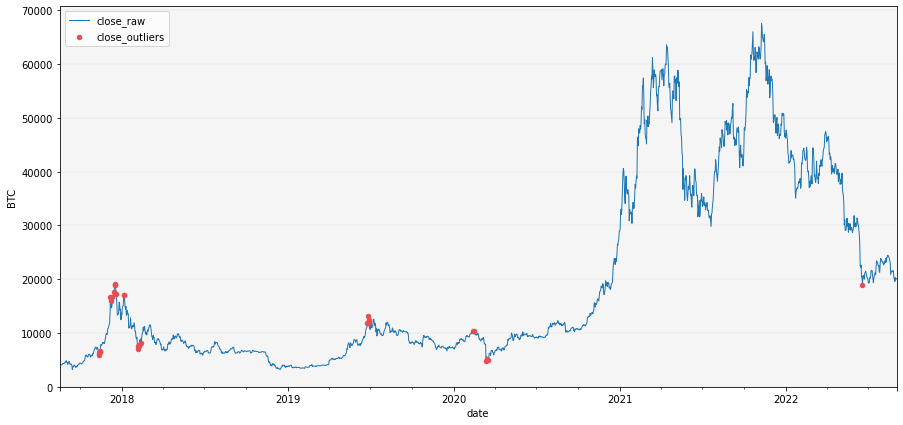

In [26]:
outliers_dict = OutlierDetection(ohlcv_df).prophet(plot=True)

In [10]:
class Filter():
    """
    Filters dataframe in tidy format.
    """

    def __init__(self, raw_df: pd.DataFrame, excl_cols: Optional[Union[str, list]] = None):
        """
        Constructor

        Parameters
        ----------
        raw_df: pd.DataFrame - MultiIndex
            Dataframe with raw data. DatetimeIndex (level 0), ticker (level 1) and raw data (cols), in tidy format.
        excl_cols: str or list, default None
            Name of columns to exclude from filtering
        """

        self.raw_df = raw_df
        self.excl_cols = excl_cols

    def outliers(self, outliers_dict: dict, plot: bool = False, plot_series: tuple = ('BTC', 'close')) -> pd.DataFrame:
        """
        Filters outliers, replacing them with NaNs.

        Parameters
        ----------
        outliers_dict: Dictionary of pd.DataFrame - MultiIndex
            Dictionary of forecasts (yhat), outliers (outliers) and filtered values (filt_vals) multiindex dataframes
            with DatetimeIndex (level 0), tickers (level 1) and fields (cols) with forecasted, outlier or filtered 
            values.
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific (ticker, field/column) tuple.

        Returns
        -------
        filt_df: DataFrame - MultiIndex
            Filtered dataFrame with DatetimeIndex (level 0), tickers (level 1) and fields (cols) with outliers removed.
        """
        # filter outliers
        filt_df = outliers_dict['filt_vals']

        # add excl cols
        if self.excl_cols is not None:
            filt_df = pd.concat([filt_df, self.raw_df[self.excl_cols]], join='outer', axis=1)

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError(
                    "Plot_series must be a tuple specifying the ticker and column/field to plot (ticker, column).")
            else:
                self.plot_filtered(filt_df, plot_series=plot_series)

        return filt_df

    def avg_trading_val(self, thresh_val: int = 10000000, window_size: int = 30,
                        plot: bool = False, plot_series: tuple = ('BTC', 'close')) -> pd.DataFrame:
        """
        Filters values below a threshold of average trading value (price * volume/size in quote currency) over some
        lookback window, replacing them with NaNs.

        Parameters
        ----------
        thresh_val: int, default 10,000,000
            Threshold/cut-off for avg trading value.
        window_size: int, default 30
            Size of rolling window.
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific (ticker, field/column) tuple.

        Returns
        -------
        filt_df: DataFrame - MultiIndex
            Filtered dataFrame with DatetimeIndex (level 0), tickers (level 1) and fields (cols) with values below the 
            threshold removed.
        """
        # convert string to list
        if self.excl_cols is not None:
            df = self.raw_df.drop(columns=self.excl_cols).copy()
        else:
            df = self.raw_df.copy()

        # compute traded val
        if 'close' in df.columns and 'volume' in df.columns:
            df['trading_val'] = (df.close * df.volume)
        elif ('bid' in df.columns and 'ask' in df.columns) and \
                ('bid_size' in df.columns and 'ask_size' in df.columns):
            df['trading_val'] = ((df.bid + df.ask) / 2) * ((df.bid_size + df.ask_size) / 2)
        elif 'trade_size' in df.columns and 'trade_price' in df.columns:
            df['trading_val'] = (df.trade_price * df.trade_size)
        else:
            raise Exception("Dataframe must include at least one price series (e.g. close price, trade price, "
                            "ask/bid price) and size series (e.g. volume, trade_size, bid_size/ask_size, ...")

        # compute rolling mean/avg
        df1 = df.groupby(level=1).rolling(window_size).mean().droplevel(0)
        # divide by thresh
        df1 = df1 / thresh_val
        # filter df1
        filt_df = df.loc[df1.trading_val > 1].reindex(df.index).drop(columns='trading_val')
        # add excl cols
        if self.excl_cols is not None:
            filt_df = pd.concat([filt_df, self.raw_df[self.excl_cols]], join='outer', axis=1)

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError(
                    "Plot_series must be a tuple specifying the ticker and column/field to plot (ticker, column).")
            else:
                self.plot_filtered(filt_df, plot_series=plot_series)

        return filt_df

    def missing_vals_gaps(self, gap_window: int = 30, plot: bool = False,
                          plot_series: tuple = ('BTC', 'close')) -> pd.DataFrame:
        """
        Filters values before a large gap of missing values, replacing them with NaNs.

        Parameters
        ----------
        gap_window: int, default 30
            Size of window where all values are missing (NaNs).
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific (ticker, field/column) tuple.

        Returns
        -------
        filt_df: DataFrame - MultiIndex
            Filtered dataFrame with DatetimeIndex (level 0), tickers (level 1) and fields (cols) with values before
            missing values gaps removed.
        """
        # convert string to list
        if self.excl_cols is not None:
            df = self.raw_df.drop(columns=self.excl_cols).copy()
        else:
            df = self.raw_df.copy()

        # window obs count
        window_count = df.groupby(level=1).rolling(window=gap_window, min_periods=gap_window).count().droplevel(0)
        gap = window_count[window_count == 0]
        # valid start idx
        for col in gap.unstack().columns:
            start_idx = gap.unstack()[col].last_valid_index()
            if start_idx is not None:
                df.loc[pd.IndexSlice[: start_idx, col[1]], col[0]] = np.nan

        # add excl cols
        if self.excl_cols is not None:
            filt_df = pd.concat([df, self.raw_df[self.excl_cols]], join='outer', axis=1)
        else:
            filt_df = df

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError(
                    "Plot_series must be a tuple specifying the ticker and column/field to plot (ticker, column).")
            else:
                self.plot_filtered(filt_df, plot_series=plot_series)

        return filt_df

    def min_nobs(self, min_obs=100) -> pd.DataFrame:
        """
        Removes tickers from dataframe if the ticker has less than a minimum number of observations.

        Parameters
        ----------
        min_obs: int, default 100
            Minimum number of observations for field/column.

        Returns
        -------
        filt_df: DataFrame - MultiIndex
            Filtered dataFrame with DatetimeIndex (level 0), tickers with minimum number of observations (level 1) 
            and fields (cols).
        """
        # create copy
        df = self.raw_df.copy()

        # drop tickers with nobs < min_obs
        nobs = df.groupby(level=1).count().min(axis=1)
        drop_tickers_list = nobs[nobs < min_obs].index.to_list()
        filt_df = df.drop(drop_tickers_list, level=1, axis=0)

        return filt_df

    def tickers(self, tickers_list) -> pd.DataFrame:
        """
        Removes specified tickers from dataframe.

        Parameters
        ----------
        tickers_list: str or list
            List of tickers to be removed. Can be used to remove tickers to be excluded from data analysis, 
            e.g. stablecoins or indexes.

        Returns
        -------
        filt_df: pd.DataFrame - MultiIndex
            Filtered dataFrame with DatetimeIndex (level 0), tickers (level 1) and fields (cols).
        """
        # create copy
        df = self.raw_df.copy()
        # tickers list
        if isinstance(tickers_list, str):
            tickers_list = [tickers_list]
        # drop tickers
        filt_df = df.drop(tickers_list, level=1, axis=0)

        return filt_df

    @staticmethod
    def plot_filtered(filt_df: pd.DataFrame, plot_series: Optional[tuple] = None) -> None:
        """
        Plots filtered time series.

        Parameters
        ----------
        filt_df: pd.DataFrame - MultiIndex
            Dataframe MultiIndex with DatetimeIndex (level 0), tickers (level 1) and filtered values (cols).
        plot_series: tuple, optional, default None
            Plots the time series of a specific (ticker, field) tuple.
        """
        ax = filt_df.loc[pd.IndexSlice[:, plot_series[0]], plot_series[1]].droplevel(1).\
            plot(linewidth=1, figsize=(15, 7), color='#1f77b4', zorder=0)
        ax.grid(color='black', linewidth=0.05)
        ax.xaxis.grid(False)
        ax.set_ylabel(plot_series[0])
        ax.ticklabel_format(style='plain', axis='y')
        ax.set_facecolor('whitesmoke')
        ax.legend([plot_series[1] + "_filtered"], loc='upper left')


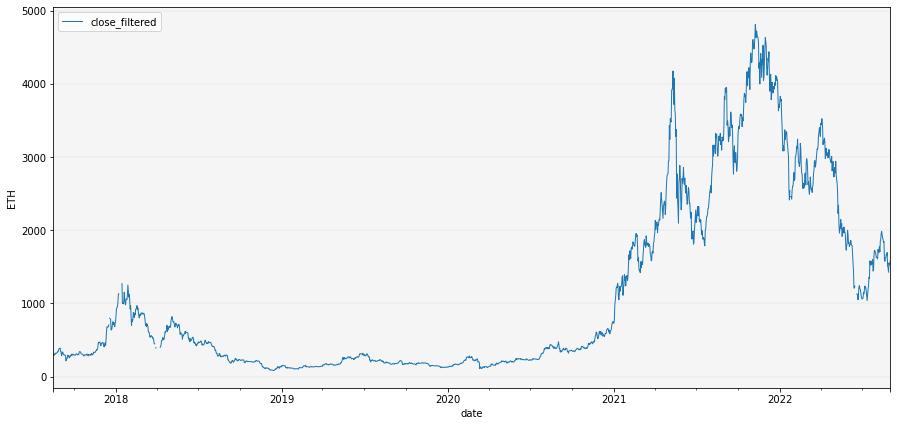

In [11]:
filt_df = Filter(ohlcv_df).outliers(outliers_dict, plot=True, plot_series=('ETH', 'close'))

In [12]:
class Impute():
    """
    Handles missing values.
    """

    def __init__(self, filt_df: pd.DataFrame):

        """
        Constructor

        Parameters
        ----------
        filt_df: pd.DataFrame - MultiIndex
            DataFrame MultiIndex with DatetimeIndex (level 0), ticker (level 1) and fields (cols) with filtered values.
        """
        self.filt_df = filt_df

    def fwd_fill(self, plot: bool = False, plot_series: tuple = ('BTC', 'close')) -> pd.DataFrame:
        """
        Imputes missing values by imputing missing values with latest non-missing values.

        Parameters
        ----------
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific (ticker, field/column) tuple.

        Returns
        -------
        imp_df: pd.DataFrame - MultiIndex
            DataFrame MultiIndex with DatetimeIndex (level 0), ticker (level 1) and fields (cols) with imputed values
            using forward fill method.
        """
        # copy df
        filt_df = self.filt_df.copy()

        # ffill
        imp_df = filt_df.groupby(level=1).ffill()

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError(
                    "Plot_series must be a tuple specifying the ticker and column/field to plot (ticker, column).")
            else:
                self.plot_imputed(imp_df, plot_series=plot_series)

        return imp_df

    def interpolate(self, method: str = 'linear', order: Optional[int] = None, axis=0,
                    limit: Optional[int] = None, plot: bool = False,
                    plot_series: tuple = ('BTC', 'close')) -> pd.DataFrame:
        """
        Imputes missing values by interpolating using various methods.

        Parameters
        ----------
        method: str, {'linear', ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘spline’, ‘barycentric’,
                      ‘polynomial’, ‘krogh’, ‘piecewise_polynomial’, ‘pchip’, ‘akima’, ‘cubicspline’}, default spline
            Interpolation method to use.
        order: int, optional, default None
            Order of polynomial or spline.
        axis: {{0 or ‘index’, 1 or ‘columns’, None}}, default None
            Axis to interpolate along.
        limit: int, optional, default None
            Maximum number of consecutive NaNs to fill. Must be greater than 0.
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific (ticker, field/column) tuple.

        Returns
        -------
        imp_df: pd.DataFrame - MultiIndex
            DataFrame MultiIndex with DatetimeIndex (level 0), ticker (level 1) and fields (cols) with imputed values
            using interpolation method.
        """
        # copy df and convert to float for interpolation (code will break if type int64)
        filt_df = self.filt_df.astype(float).copy()

        # add order if spline or polynomial
        if (method == 'spline' or method == 'polynomial') and order is None:
            order = 3

        # interpolate
        imp_df = filt_df.unstack().interpolate(method=method, order=order, axis=axis, limit=limit).\
            stack().reindex(filt_df.index)

        # type conversion
        imp_df = imp_df.apply(pd.to_numeric, errors='ignore').convert_dtypes()

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError(
                    "Plot_series must be a tuple specifying the ticker and column/field to plot (ticker, column).")
            else:
                self.plot_imputed(imp_df, plot_series=plot_series)

        return imp_df

    def fcst(self, fcst_df: pd.DataFrame, plot: bool = False, plot_series: tuple = ('BTC', 'close')) -> pd.DataFrame:
        """
        Imputes missing values with forecasts from outlier detection algorithm.

        Parameters
        ----------
        fcst_df: pd.DataFrame - MultiIndex
            Multiindex dataframe with DatetimeIndex (level 0), tickers (level 1) and fields (cols)
            with forecasted values.
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific (ticker, field/column) tuple.

        Returns
        -------
        imp_df: pd.DataFrame - MultiIndex
            DataFrame MultiIndex with DatetimeIndex (level 0), ticker (level 1) and fields (cols) with imputed values
            using forecasts from outlier detection method.
        """
        # copy filtered and forecast dfs
        filt_df, yhat_df = self.filt_df.copy(), fcst_df.copy()

        # impute missing vals in filtered df with fcst vals
        imp_yhat = np.where(filt_df.isna(), yhat_df, filt_df)
        # create df
        imp_df = pd.DataFrame(imp_yhat, index=filt_df.index, columns=filt_df.columns)

        # type conversion
        imp_df = imp_df.apply(pd.to_numeric, errors='ignore').convert_dtypes()

        # plot
        if plot:
            if not isinstance(plot_series, tuple):
                raise TypeError(
                    "Plot_series must be a tuple specifying the ticker and column/field to plot (ticker, column).")
            else:
                self.plot_imputed(imp_df, plot_series=plot_series)

        return imp_df

    @staticmethod
    def plot_imputed(imp_df: pd.DataFrame, plot_series: Optional[tuple] = None) -> None:
        """
        Plots filtered time series.

        Parameters
        ----------
        imp_df: pd.DataFrame - MultiIndex
            DataFrame MultiIndex with DatetimeIndex (level 0), ticker (level 1) and fields (cols) with imputed values.
        plot_series: tuple, optional, default None
            Plots the time series of a specific (ticker, field) tuple.
        """
        ax = imp_df.loc[pd.IndexSlice[:, plot_series[0]], plot_series[1]].droplevel(1).\
            plot(linewidth=1, figsize=(15, 7), color='#1f77b4', zorder=0)
        ax.grid(color='black', linewidth=0.05)
        ax.xaxis.grid(False)
        ax.set_ylabel(plot_series[0])
        ax.ticklabel_format(style='plain', axis='y')
        ax.set_facecolor('whitesmoke')
        ax.legend([plot_series[1] + "_repaired"], loc='upper left')


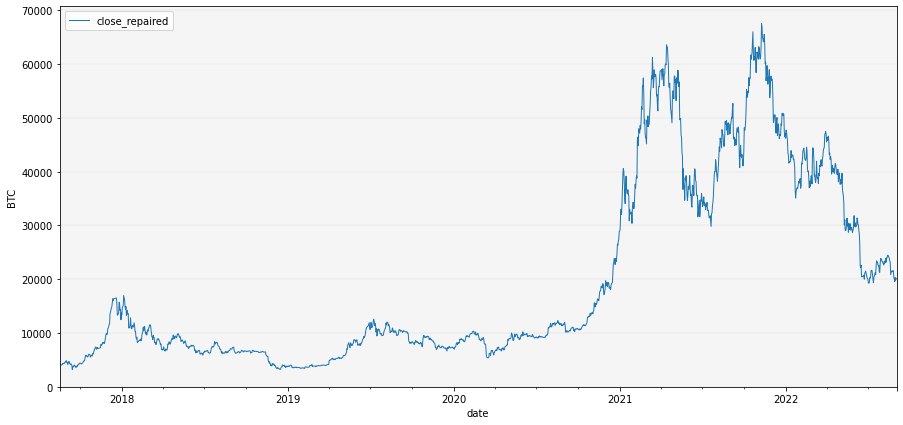

In [13]:
imp_df = Impute(filt_df).interpolate(plot=True, plot_series=('BTC', 'close'))

In [19]:
class CleanData():
    """
    Cleans data to improve data quality.
    """

    def __init__(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Constructor

        Parameters
        ----------
        df: pd.DataFrame
            DataFrame MultiIndex with DatetimeIndex (level 0), ticker (level 1) and field (cols) values.
        """
        self.df = df
        self.start_df = df.copy()  # keepy copy of raw dataframe
        self.outliers = None  # outliers
        self.fcsts = None  # forecasts
        self.filtered_tickers = []  # filtered tickers
        self.summary = pd.DataFrame()  # summary of cleaning ops
        # add obs and missing vals
        self.summary.loc['n_obs', self.df.unstack().columns] = self.df.unstack().notna().sum().values
        self.summary.loc['%_NaN_start', self.df.unstack().columns] = (self.df.unstack().isnull().sum()/self.df.unstack().shape[0]).values * 100

    def filter_outliers(self, excl_cols: Optional[Union[str, list]] = None, od_method: str = 'z_score', **kwargs) -> pd.DataFrame:
        """
        Filters outliers.
        
        Parameters
        ----------
        excl_cols: str or list
            Name of columns to exclude from outlier filtering.
        od_method: str, {'atr', 'iqr', 'mad', 'z_score', 'ewma', 'stl', 'seasonal_decomp', 'prophet'}, default z_score
            Outlier detection method to use for filtering.
            
        Other Parameters
        ----------------
        log: bool, default False
            Converts series into log of series.
        window_size: int, default 7
            Number of observations in the rolling window.
        model_type: str, {'estimation', 'prediction'}, default 'estimation'
            Estimation models use past, current and future values to estimate the expected value of a series,
            e.g. expected x_t of series x at time t uses values from [x_t-s, x_t+s].
            Prediction models use only past and current values to estimate the expected value of a series,
            e.g. expected x_t of series x at time t uses values from [x_t-s, x_t].
        thresh_val: int, default 2
            Value for upper and lower thresholds used in outlier detection.
        period: int, optional, default 7
            periodicity of the sequence.
        model: str, {'additive', 'multiplicative'}, default 'additive'
            Type of seasonal component.
        filt: array-like, optional, default None
            The filter coefficients for filtering out the seasonal component.
            The concrete moving average method used in filtering is determined by two_sided.
        two_sided: bool, optional, default True
            The moving average method used in filtering. If True (default), a centered moving average is
            computed using the filt. If False, the filter coefficients are for past values only.
        extrapolate_trend: int, optional, default 0
            If set to > 0, the trend resulting from the convolution is linear least-squares extrapolated
            on both ends (or the single one if two_sided is False) considering this many (+1) closest points.
            If set to ‘freq’, use freq closest points. Setting this parameter results in no NaN values in trend
            or resid components.
        seasonal_deg: int, optional, default 1
            Degree of seasonal LOESS. 0 (constant) or 1 (constant and trend).
        trend_deg: int, optional, default 1
            Degree of trend LOESS. 0 (constant) or 1 (constant and trend).
        low_pass_deg: int, optional, default 1
            Degree of low pass LOESS. 0 (constant) or 1 (constant and trend).
        robust: bool, optional, default False
            Flag indicating whether to use a weighted version that is robust to some forms of outliers.
        seasonal_jump: int, optional, default 1
            Positive integer determining the linear interpolation step. If larger than 1,
            the LOESS is used every seasonal_jump points and linear interpolation is between fitted points.
            Higher values reduce estimation time.
        trend_jump: int, optional, default 1
            Positive integer determining the linear interpolation step. If larger than 1,
            the LOESS is used every trend_jump points and values between the two are linearly interpolated.
            Higher values reduce estimation time.
        low_pass_jump: int, optional, default 1
            Positive integer determining the linear interpolation step. If larger than 1,
            the LOESS is used every low_pass_jump points and values between the two are linearly interpolated.
            Higher values reduce estimation time.
        interval_width: float, optional, default 0.99
            Uncertainty interval estimated by Monte Carlo simulation. The larger the value,
            the larger the upper/lower thresholds interval for outlier detection.
        plot: bool, default False
            Plots series with outliers highlighted (red dots).
        plot_series: tuple, default ('BTC', 'close')
            The specific time series to plot given by (ticker, field/column) tuple.
    
        Returns
        -------
        self: object
            Returns GetData object
        """
        # outlier detection 
        od = getattr(OutlierDetection(self.df), od_method)(**kwargs)
        # add outliers and fcst to obj
        self.outliers = od['outliers']
        self.fcsts = od['yhat']
        # filter outliers
        filt_df = Filter(self.df, excl_cols=excl_cols).outliers(od)
        # add to summary 
        self.summary.loc['%_outliers', self.df.unstack().columns] = (od['outliers'].unstack().notna().sum() / self.df.unstack().shape[0]).values * 100
        # filtered df
        self.df = filt_df
        
        return self
    
    def repair_outliers(self, imp_method: str = 'interpolate', **kwargs) -> pd.DataFrame:
        """
        Repairs outliers using an imputation method.
        
        Parameters
        ----------
        imp_method: str, {"fwd_fill', 'interpolate', 'fcst'}, default 'fwd_fill'
            Imputation method used to replace filtered outliers.
            
        Other Parameters
        ----------------
        method: str, {'linear', ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘spline’, ‘barycentric’,
                      ‘polynomial’, ‘krogh’, ‘piecewise_polynomial’, ‘pchip’, ‘akima’, ‘cubicspline’}, default spline
            Interpolation method to use.
        order: int, optional, default None
            Order of polynomial or spline.
        axis: {{0 or ‘index’, 1 or ‘columns’, None}}, default None
            Axis to interpolate along.
        limit: int, optional, default None
            Maximum number of consecutive NaNs to fill. Must be greater than 0.
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific (ticker, field/column) tuple.
        
        Returns
        -------
        self: object
            Returns GetData object
        """
        # impute missing vals
        if imp_method == 'fcst':
            rep_df = getattr(Impute(self.df), imp_method)(self.fcsts, **kwargs)
        else:
            rep_df = getattr(Impute(self.df), imp_method)(**kwargs)
        # add repaired % to summary 
        rep_vals = rep_df.unstack().notna().sum() - self.df.unstack().notna().sum()
        self.summary.loc['%_repaired', self.df.unstack().columns] = (rep_vals / self.df.unstack().shape[0]) * 100
        # repaired df
        self.df = rep_df
        
        return self
    
    def filter_avg_trading_val(self, thresh_val: int = 10000000, window_size: int = 30, **kwargs) -> pd.DataFrame:
        """
        Filters values below a threshold of average trading value (price * volume/size in quote currency) over some
        lookback window, replacing them with NaNs.

        Parameters
        ----------
        thresh_val: int, default 10,000,000
            Threshold/cut-off for avg trading value.
        window_size: int, default 30
            Size of rolling window.
            
        Other Parameters
        ----------------
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific (ticker, field/column) tuple.
   
        Returns
        -------
        self: object
            Returns GetData object
        """
        # filter outliers
        filt_df = Filter(self.df).avg_trading_val(thresh_val=thresh_val, window_size=window_size, **kwargs)
        # add to summary 
        filt_vals = self.df.unstack().notna().sum() - filt_df.unstack().notna().sum()
        self.summary.loc['%_below_avg_trading_val', self.df.unstack().columns] = (filt_vals / self.df.unstack().shape[0]).values * 100
        # filtered df
        self.df = filt_df
        
        return self
    
    def filter_missing_vals_gaps(self, gap_window: int = 30, **kwargs) -> pd.DataFrame:
        """
        Filters values before a large gap of missing values, replacing them with NaNs.

        Parameters
        ----------
        gap_window: int, default 30
            Size of window where all values are missing (NaNs).
            
        Other Parameters
        ----------------
        plot: bool, default False
            Plots series with outliers highlighted with red dots.
        plot_series: tuple, default ('BTC', 'close')
            Plots the time series of a specific (ticker, field/column) tuple.
   
        
        Returns
        -------
        self: object
            Returns GetData object
        """
        # filter outliers
        filt_df = Filter(self.df).missing_vals_gaps(gap_window=gap_window, **kwargs)
        # add to summary 
        missing_vals_gap = self.df.unstack().notna().sum() - filt_df.unstack().notna().sum()
        self.summary.loc['%_missing_vals_gaps', self.df.unstack().columns] = (missing_vals_gap / self.df.unstack().shape[0]).values * 100
        # filtered df
        self.df = filt_df
        
        return self
      
    def filter_min_nobs(self, min_obs=100) -> pd.DataFrame:
        """
        Removes tickers from dataframe if the ticker has less than a minimum number of observations.

        Parameters
        ----------
        min_obs: int, default 100
            Minimum number of observations for field/column.
        
        Returns
        -------
        self: object
            Returns GetData object
        """
        # filter outliers
        filt_df = Filter(self.df).min_nobs(min_obs=min_obs)
        # tickers < min obs
        filt_tickers = list(set(filt_df.index.droplevel(0).unique()).symmetric_difference(set(self.df.index.droplevel(0).unique())))
        # add to obj
        if len(filt_tickers) !=0:
            self.filtered_tickers.extend(filt_tickers)
        self.summary.loc['n_tickers_below_min_obs', self.df.unstack().columns] = len(filt_tickers) 
        # filtered df
        self.df = filt_df
        
        return self
    
    def filter_tickers(self, tickers_list) -> pd.DataFrame:
        """
        Removes specified tickers from dataframe.

        Parameters
        ----------
        tickers_list: str or list
            List of tickers to be removed. Can be used to remove tickers to be excluded from data analysis, 
            e.g. stablecoins or indexes.  
        
        Returns
        -------
        self: object
            Returns GetData object
        """
        # filter tickers
        filt_df = Filter(self.df).tickers(tickers_list)
        # tickers < min obs
        filt_tickers = list(set(filt_df.index.droplevel(0).unique()).symmetric_difference(set(self.df.index.droplevel(0).unique())))
        # add to obj properties
        if len(filt_tickers) !=0:
            self.filtered_tickers.extend(filt_tickers)
        self.summary.loc['n_filtered_tickers', self.df.unstack().columns] = len(filt_tickers)
        # filtered df
        self.df = filt_df
        
        return self
    
    def show_plot(self, plot_series: tuple = ('BTC', 'close'), compare_series: bool = True) -> None:
        """
        Plots clean time series and compares it to the raw series.
        
        Parameters
        ----------
        plot_series: tuple, optional, default('BTC', 'close')
            Plots the time series of a specific (ticker, field) tuple.
        compare_series: bool, default True
            Compares clean time series with raw series
        """
        ax = self.df.loc[pd.IndexSlice[:,plot_series[0]], plot_series[1]].droplevel(1).\
        plot(linewidth=1, figsize=(15, 7), color='#1f77b4', zorder=0, title='Filtered vs. Raw Data')
        if compare_series:
            ax = self.start_df.loc[pd.IndexSlice[:,plot_series[0]], plot_series[1]].droplevel(1).\
            plot(linewidth=1, figsize=(15, 7), linestyle=':', color='#FF8785', zorder=0)
        ax.grid(color='black', linewidth=0.05)
        ax.xaxis.grid(False)
        ax.set_ylabel(plot_series[0])
        ax.ticklabel_format(style='plain', axis='y')
        ax.set_facecolor('whitesmoke')
        ax.legend([plot_series[1]+"_filtered", plot_series[1]+"_raw"], loc='upper left')
        
    def get(self, attr='df') -> Any:
        """
        Returns GetData object attribute.
        
        Parameters
        ----------
        attr: str, {'df', 'outliers', 'fcst', 'filtered_tickers', 'summary'}, default 'df'
            GetData object attribute to return
            
        Returns
        -------
        self: Any
            Returns GetData oject attribute
        """
        self.summary.loc['%_NaN_end', self.df.unstack().columns] = (self.df.unstack().isnull().sum()/self.df.unstack().shape[0]).values * 100
        self.summary = self.summary.astype(float).round(2)
        
        return getattr(self, attr)
        

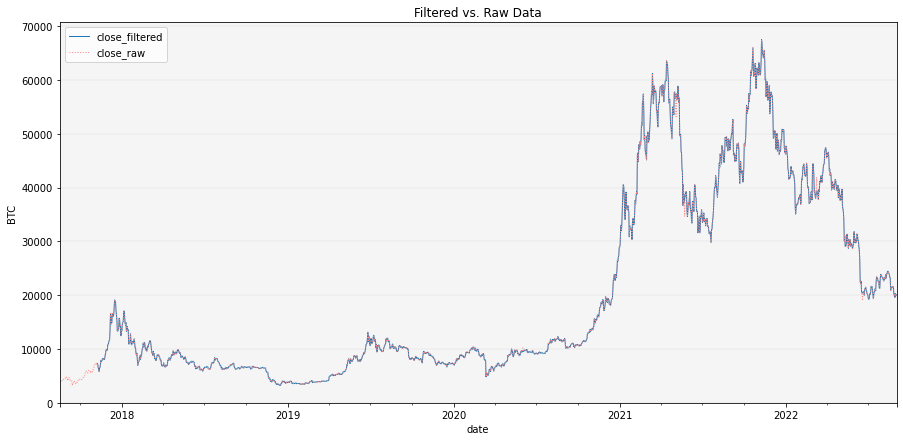

In [37]:
CleanData(ohlcv_df).\
filter_outliers().\
repair_outliers().\
filter_avg_trading_val().\
filter_missing_vals_gaps().\
filter_min_nobs(min_obs=1000).\
filter_tickers(tickers_list='ETH').show_plot()
